# Análise texto bioquímico usando ferramentas de NLP

## Nosso objetivo aqui é como podemos analisar e visualizar informações de textos extraídos via web scrapy usando as ferramentas de processamento de linguagem natural NLP. Nesse trabalho é introdutório, servindo mais como exercício das ferramentas de NLP. Os textos alvos são referentes a textos sobre bioquímica de produtos naturais. A biblioteca nltk permite que possamos fazer um tratamento inicial do texto, onde eliminamos as stopwords, pontuações, colchetes etc. Realizamos a lematização que reduzir as palavras a sua forma base desse modo reduzindo a complexidade do texto. Uma informação muito importante que podemos extrair de um texto e o reconhecimento de entidade nomeada [Named Entity Recognition](https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da). 

## Nessa análise usamos textos no idioma inglês, contudo podemos facilmente adaptar os algoritmos para qualquer outro idioma apenas baixando o dicionário correspondente. No final salvamos alguns dados produzidos em arquivos csv e salvando em um banco de dados MySQL.

## 1 [Extraindo informações preliminares](#1)
   ## 1.1 [Carregando o arquivo .txt com os dados](#2)
   ## 1.2 [Mostrando os termos mais frequentes e salvando em arquivo .csv](#3)
## 3. [Removendo Stopwords](#4)
## 4. [Lemmatização](#5)
## 5. [Análise N-gram  do texto](#6)
## 6. [Nuvem de palavras](#7)
## 7. [Reconhecendo entidades nomeadas](#8)
   ## 7.1 [Criando conteiner do arquivo](#9)
   ## 7.2 [Identificarmos sentenças do texto](#10)
   ## 7.3 [Identificando as classes gramaticais.](#11)
   ## 7.4 [Mostrando entidades nomeadas](#12)
## 8. [Salvando os arquivos gerados em banco de dados MySQL](#13)

In [1]:
# Importando bibliotecas necessárias
import codecs
import re
import copy
import collections

import numpy as np
import pandas as pd
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import WordPunctTokenizer, word_tokenize
from __future__ import division

import string
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

<a id = "1" ></a>
# Extraindo informações preliminares

<a id = "2" ></a>
## Carregando o arquivo .txt com os dados

In [2]:
with codecs.open("Biochemistry_natural_products.txt", "r", encoding="utf-8") as f:
    bio = f.read()

<a id = "3" ></a>
## Mostrando os termos mais frequentes e salvando em arquivo .csv

In [3]:
# Aplicando os stopwords
esw = stopwords.words('english')
esw.append("would")
word_pattern = re.compile("^\w+$")

In [4]:
# Criando uma função para contar os termos no texto
def get_text_counter(text):
    tokens = WordPunctTokenizer().tokenize(PorterStemmer().stem(text))
    tokens = list(map(lambda x: x.lower(), tokens))
    tokens = [token for token in tokens if re.match(word_pattern, token) and token not in esw]
    return collections.Counter(tokens), len(tokens)

# Criando uma função para gerar um arquivo csv com os termos mais frquentes
def make_df(counter, size):
    abs_freq = np.array([el[1] for el in counter])
    rel_freq = abs_freq / size
    index = [el[0] for el in counter]
    df = pd.DataFrame(data=np.array([abs_freq, rel_freq]).T, index=index, columns=["Absolute frequency", "Relative frequency"])
    df.index.name = "Most common words"
    df.to_csv('bio_freq.csv', index = True)
    return df

In [5]:
# Criando o arquivo "bio_freq.csv" com os 20 termos mais frequentes.
bio_counter, bio_size = get_text_counter(bio)
make_df(bio_counter.most_common(20), bio_size)

,Absolute frequency,Relative frequency
Most common words,,
natural,107.0,0.015308
products,66.0,0.009442
edit,50.0,0.007153
amino,43.0,0.006152
chemical,42.0,0.006009
acids,42.0,0.006009
acid,42.0,0.006009
product,39.0,0.005579
chemistry,39.0,0.005579


In [6]:
# Carregando o arquivo cvs "bio_freq.csv"
df = pd.read_csv('bio_freq.csv')
df.head()

,Most common words,Absolute frequency,Relative frequency
0,natural,107.0,0.015308
1,products,66.0,0.009442
2,edit,50.0,0.007153
3,amino,43.0,0.006152
4,chemical,42.0,0.006009


<a id = "4" ></a>
# Removendo Stopwords

### Aqui vamos remover as palavras irrevantes (Stopwords) que aparecem com frequência no texto que trazem pouca ou nenhuma informação.  Como exemplo de stopwords temos and, the, for ect.

In [7]:
# Como nosso texto esta em inglês vamos carregar o dicionário em inglês 
stop = set(stopwords.words('english'))
# Removendo sinais de pontuação
punctuation = list(string.punctuation)
# Adicionando pontuações à lista de palavras de parada 
stop.update(punctuation)

# Removendo os colchetes
def remove_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removendo as URLs
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

# Removendo as palavras irrelevantes do texto
def remove_stopwords(text):
    final_text = []
    text = text.lower()
    for i in text.split():
        if i.strip() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

# Removendo ruidos no texto
def clean_text(text):
    text = remove_brackets(text)
    text = remove_urls(text)
    text = remove_stopwords(text)
    return text

# Aplicar função no texto
bio=clean_text(bio)


<a id = "5" ></a>
# Lemmatização

### Aqui devemos fazer a lematização, onde convertemos uma palavra para sua forma básica. Como exemplo 'getting' é reduzida para forma base  
### 'get'. Este processo reduz a complexidade do texto.

In [8]:
lemmatizer = WordNetLemmatizer()

# Criando uma função que pega uma frase/corpus e obtém sua versão lematizada.
def lemmatize_text(text):
    token_words=word_tokenize(text) 
# Precisamos tokenizar a frase ou então a lematização retornará a frase inteira como está
    lemma_sentence=[]
    for word in token_words:
        lemma_sentence.append(lemmatizer.lemmatize(word))
        lemma_sentence.append(" ")
    return "".join(lemma_sentence)

#  Aplicando a função sobre o texto bio
bios = lemmatize_text(bio)

<a id = "6" ></a>
# Análise N-gram  do texto

## Um N-gram é uma sequência ligada de N itens de uma determinada amostra de texto ou fala. Esse modelo é um tipo de modelo de linguagem probabilístico para prever o próximo item em tal sequência na forma de um modelo de Markov. Modelos N-gram são amplamente usados ​​no processamento estatístico de linguagem natural. No reconhecimento de fala, fonemas e sequências de fonemas são modelados usando uma distribuição de N-gram. Devido às várias aplicações da análise de N-gram, é importante mostrar como lidar com elas.

In [9]:
# Encontrando N-grams
texts = ''.join(list(bios))

# Primeiro obtendo as palavras individuias
tokenized = texts.split()

Text(0.5, 0, '# de ocorrência')

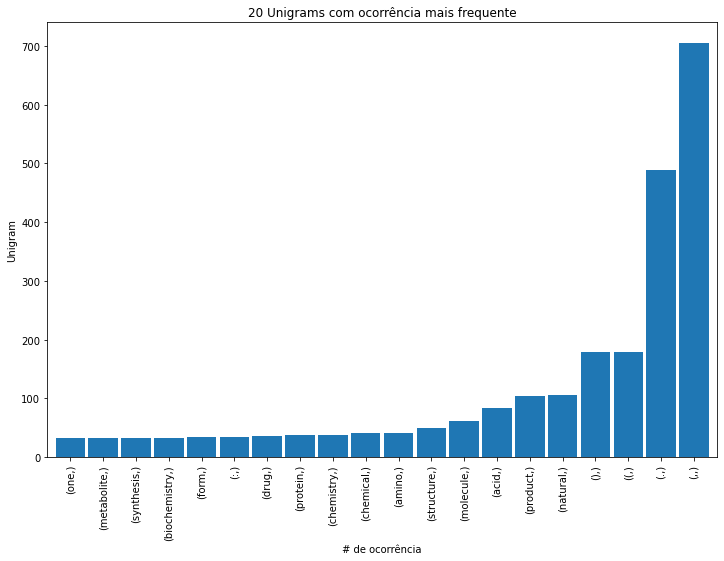

In [10]:
# Plotando termos 1-gram 
unigram = (pd.Series(nltk.ngrams(tokenized, 1)).value_counts())[:20]
unigram.sort_values().plot.bar(width=.9, figsize=(12, 8))
plt.title('20 Unigrams com ocorrência mais frequente')
plt.ylabel('Unigram')
plt.xlabel('# de ocorrência')

Text(0.5, 0, '# de ocorrência')

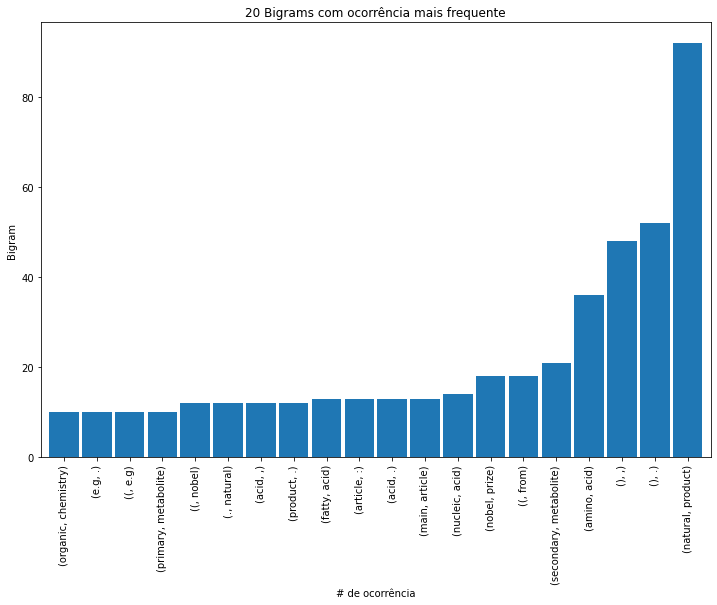

In [11]:
# Plotando termos 2-gram 
bigram = (pd.Series(nltk.ngrams(tokenized, 2)).value_counts())[:20]
bigram.sort_values().plot.bar(width=.9, figsize=(12, 8))
plt.title('20 Bigrams com ocorrência mais frequente')
plt.ylabel('Bigram')
plt.xlabel('# de ocorrência')

Text(0.5, 0, '# de ocorrência')

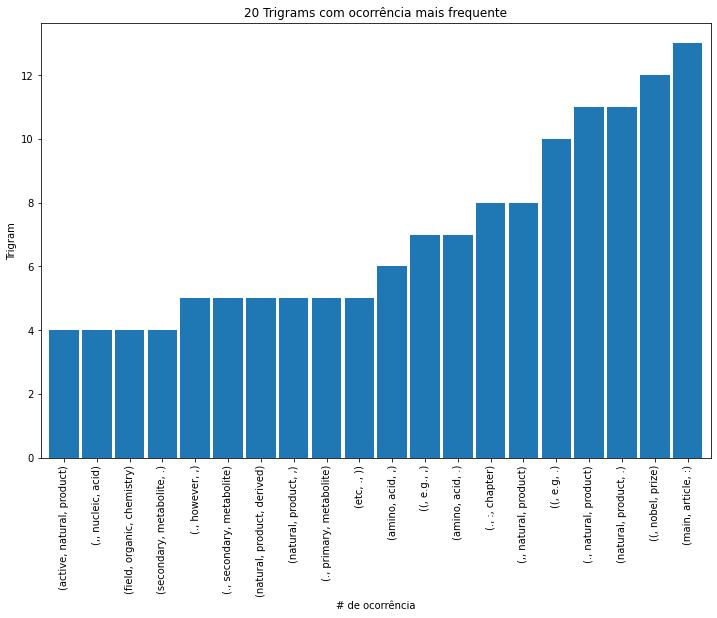

In [12]:
# Plotando termos 3-gram 
trigram = (pd.Series(nltk.ngrams(tokenized, 3)).value_counts())[:20]
trigram.sort_values().plot.bar(width=.9, figsize=(12, 8))
plt.title('20 Trigrams com ocorrência mais frequente')
plt.ylabel('Trigram')
plt.xlabel('# de ocorrência')

<a id = "7" ></a>
# Nuvem de palavras

## Uma nuvem de palavras é uma coleção, ou agrupamento, de palavras representadas em tamanhos diferentes. Quanto maior e mais destacada a palavra aparecer, mais frequentemente ela será mencionada em um determinado texto e mais importante será. Eles podem ajudar os usuários de negócios a comparar e contrastar duas partes diferentes de texto para encontrar as semelhanças de redação entre os dois, por exemplo.

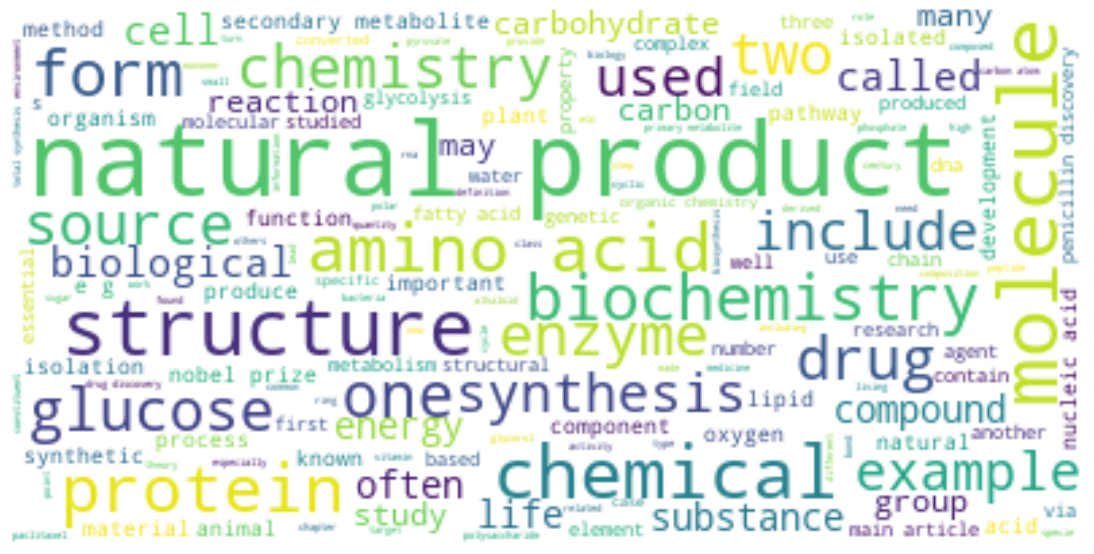

In [13]:
# Nuvem de palavras para texto 'Biochemistry_and_Natural_Products'
cloud = WordCloud(max_words = 500, stopwords = STOPWORDS, background_color = "white").generate(bios)
plt.figure(figsize=(15, 18))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

<a id = "8" ></a>
# Reconhecendo entidades nomeadas

## As ferramentas de Natural Language Processing (NLP) permitem atualmente extrairmos informações de grandes quantidades de dados em forma de texto. Uma informação muito buscada em textos é chamada Reconhecimento de Entidade Nomeada (NER, sigla do termo em inglês Named Entity Recognition). Inicialmente o NER foi desenvolvido como uma técnica para a extração de tópicos gerais, como nomes de pessoas e localizações geográficas, a partir de textos não estruturados, como artigos de jornais.

## Usaremos a poderosa biblioteca do python chamada Spacy para identificar as NERs em nosso texto.

In [14]:
# Importando a biblioteca spacy
import spacy
# Carregando o dicionário em inglês no spacy
nlp = spacy.load('pt_core_news_sm')

<a id = "9" ></a>
## Criando conteiner do arquivo

In [15]:
 # Criando  containe doc para amazenar o nosso texto
doc = nlp(bio)

In [16]:
# Mostrando a quantidade de termos.
print (len(doc))

8315


In [17]:
# Podemos criar e exibr tokens 
for token in doc[:12]:
    print(token)

chemical
compound
substance
produced
living
organism
,
found
nature
anticancer
drug
paclitaxel


<a id = "10" ></a>
## Identificarmos sentenças do texto

In [18]:
# A biblioteca spacy permite identificarmos as sentenças expressas no texto ou seja a ideia expressa pelo sujeito e predicado.
for sent in doc.sents:
    print (sent)

chemical compound substance produced living organism, found nature anticancer drug paclitaxel natural product derived yew tree.
natural product chemical compound substance
produced living organism—
that is, found nature.
broadest sense, natural products include substance produced life.
natural products also prepared chemical synthesis (both semisynthesis total synthesis) played central
role development field organic chemistry providing challenging
synthetic targets.
term natural product also extended commercial purposes refer cosmetics, dietary supplements, foods produced natural sources without added artificial ingredients.
within field organic chemistry, definition natural products usually restricted organic compounds isolated natural sources produced pathways primary secondary metabolism.
within field medicinal chemistry, definition often restricted secondary metabolites.
secondary metabolites essential survival, nevertheless provide organisms produce evolutionary advantage.
many se

In [19]:
# Podemos selecionar apenas a primera setença em particular
sentence1 = list(doc.sents)[0]
print (sentence1)

chemical compound substance produced living organism, found nature anticancer drug paclitaxel natural product derived yew tree.


<a id = "11" ></a>
## Identificando as classes gramaticais.

In [20]:
# SpaCy oferece uma maneira fácil de analisar um texto e identificar suas classes gramaticais. A seguir, faremos uma 
# iteração em cada token (palavra ou pontuação) no texto e identificaremos sua classe gramatical.
for token in sentence1:
    print (token.text, token.pos_, token.dep_)

chemical NOUN amod
compound ADJ amod
substance NOUN nsubj
produced ADJ amod
living NOUN appos
organism ADJ amod
, PUNCT punct
found NOUN appos
nature VERB ROOT
anticancer VERB xcomp
drug VERB parataxis
paclitaxel NOUN obj
natural ADJ amod
product VERB parataxis
derived VERB xcomp
yew PROPN nsubj
tree PROPN amod
. PUNCT punct


In [21]:
# Podemos ver a interlação das classes gramáticais na sentença usando o recurso abaixo
from spacy import displacy
displacy.render(sentence1, style="dep")

<a id = "11" ></a>
## Mostrando entidades nomeadas.

In [22]:
# Reconhecendo entidade nomeada no texto
for ent in doc.ents:
    print (ent.text, ent.label_)

chemical compound LOC
found nature PER
found nature PER
broadest sense PER
produced LOC
both semisynthesis total MISC
dietary supplements PER
sources without PER
compounds isolated PER
sources produced PER
definition PER
produce evolutionary advantage MISC
many LOC
cytotoxic selected PER
agents prey MISC
predators PER
competing organisms ORG
discovery MISC
profit concerns MISC
loss sources LOC
extinction rates PER
broadest definition ORG
includes likes biotic MISC
silk PER
bioplastics LOC
cornstarch LOC
bodily fluids MISC
plant exudates PER
coal LOC
restrictive definition PER
organic compound ORG
remainder article PER
narrow definition PER
natural products may classified according biological function ORG
biosynthetic pathway PER
one MISC
function following albrecht kossel's MISC
primary LOC
ability LOC
especially within field PER
defined primary PER
restrictive definition PER
used within fields medicinal PER
primary LOC
required LOC
energy production PER
growth PER
development MISC
wid

In [23]:
displacy.render(sentence1, style="ent")

In [24]:
# Podemos selecionar as REN das dez primeiras setenças do texto
i = 0
while i < 10:
    sentence = list(doc.sents)[i]
    x = displacy.render(sentence, style="ent")
    print(x)
    i +=  1

None


C:\Users\rondi\anaconda3\lib\site-packages\spacy\displacy\__init__.py:191: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


None


None


None


None


None


None


None


None


None


<a id = "12" ></a>
# Salvando os arquivos gerados em banco de dados MySQL

In [25]:
# A biblioteca sqlalchemy é a responsável por criar uma engine de conexão.
import sqlalchemy
import pymysql

In [26]:
# Criando nossa conexão com o banco de dados MySQL
engine = sqlalchemy.create_engine('mysql+pymysql://root:''@localhost:3306/cadastros')

In [28]:
# Covertendo o DataFrame df em um tabela no banco de dados MySQL
df.to_sql(
  name = 'ocorrencia_de_palavras',
  con = engine,
)